### Kalman filter

Heavily inspired by weekly project week 7 and exercise 2 week 7

***Kalman notes***
- Slowing down before occlusion effect.
- Differently tuned filteres for with and without occlusion.
- Stop trusting measurements as we get too close to occlusion.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Kalman filter model**, simple 2d model of world.
- x,y, vx, vy.
- Constant speed, ax, ay = 0


**4 measurements**

In [3]:
### Initialize Kalman filter ###
# The initial state (4x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Velocity along the x-axis 
              [0],  # Position along the y-axis
              [0]]) # Velocity along the y-axis 


# The initial uncertainty (4x4) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0]])

# The external motion (4x1).
u = np.array([[0], [0], [0], [0]])  # - no external motion 

# The transition matrix (4x4). 
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# The observation matrix (4x4).
H = np.identity(4)              #H = np.array([[1, 0, 0, 0],
                                #              [0, 1, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

**2 measurements**

In [4]:
### Initialize Kalman filter ###
# The initial state (4x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Velocity along the x-axis 
              [0],  # Position along the y-axis
              [0]]) # Velocity along the y-axis 


# The initial uncertainty (4x4) - We start with some very large values.
# Then we will fully trust measurements first iteration.
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0]])

# The external motion (4x1).
u = np.array([[0], [0], [0], [0]])  # - no external motion 

# The transition matrix (4x4). 
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# The observation matrix (2x4).
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 1*np.array([[1, 0],
                [0, 1]])

# Disturbance matrix
# How little do you want to trust the model?
Q = 1*np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

***TODO***
- Multiobject tracking: stop tracking when object leaves frame, and restart tracking (restart x, P matrices)

**Base algorithm**

In [8]:
'''
running = True
x_range = np.arange(-10, 30, 0.1) # Range of possible xpos
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,6))

# Measurement and state history
zs = []
xs = []

# Flag for new measurements
new_measurement = None

while running:
    if new_measurement:
        # Fresh measurements!
        z = np.array([[...], # xpos
                    [...],   # velx
                    [...],   # ypos
                    [...]])  # vely
        zs.append(z)

        # Update based on new measurements + previous prediction
        x, P = update(x, P, z, H, R)
    else:
        zs.append([None])


    # Predict based on model
    x, P = predict(x, P, F, u, Q)
    xs.append(x)


    # Do some plotting
    #plt.plot(axis, f(x[0], P[0, 0], axis)) # PosX
    ax[0, 0].plot(x_range, f(x[0], P[0, 0], x_range)) # PosX
    ax[0, 1].plot(x_range, f(x[1], P[1, 1], x_range)) # VelX
    ax[1, 0].plot(x_range, f(x[2], P[2, 2], x_range)) # PosY
    ax[1, 1].plot(x_range, f(x[3], P[3, 3], x_range)) # VelY

# plt.title("xpos")
# plt.show()
ax[0, 0].set_title("x pos")
ax[0, 1].set_title("x vel")
ax[1, 0].set_title("y pos")
ax[1, 1].set_title("y vel")
''';

### Kalman on Hassans tracker

In [20]:
from tracker import *
import imutils 
import glob
%run tracker.py

In [78]:

# Create tracker object
tracker = EuclideanDistTracker()

#images = glob.glob("video/sample/left/*.png")
#images = glob.glob("video/full/without_occlusions/left/*.png")
images = glob.glob("video/full/with_occlusions/left/*.png")

no_of_frames = len(images)-1
print("Frames:", no_of_frames)

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=40)
xs = []
ys = []

for i in range(no_of_frames):
    frame = cv2.imread(images[i])    
    height, width, _ = frame.shape

    # Extract Region of interest
    rotated = imutils.rotate_bound(frame, 15)
    rotated2=rotated[450:800,350:1250]
    roi = imutils.rotate_bound(rotated2, -15)

    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 20, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(mask, None, iterations=6)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []

    biggest_area=0
    best_cnt = None
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area>biggest_area:
            biggest_area=area
            best_cnt = cnt
    if biggest_area>2000:
        x, y, w, h = cv2.boundingRect(best_cnt)
        detections.append([x, y, w, h])
    # 2. Object Tracking
    boxes_ids = tracker.update(detections)
    if len(detections): # We have seen an object
        for box_id in boxes_ids:
            x, y, w, h, id = box_id
            x=x-25
            y=y-25
            w=w+50
            h=h+50
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 255, 0), 3)
            #cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
            # For KALMAN FILTER
            xs.append(x + w//2)
            ys.append(y + h//2)

    else: # No object detected
        # For KALMAN FILTER
        xs.append(None)
        ys.append(None)


    cv2.imshow("roi", roi)
    #cv2.imshow("Frame", frame)
    #cv2.imshow("Mask", thresh)

    # For nice visualization
    #cv2.waitKey(30)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        break

cv2.destroyAllWindows()

Frames: 1452


In [79]:

measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
print("measurements", measurements.shape)

measurements (2, 1452)


Kalman filtered states (4, 1452)
Average xvel: 0.8617316529211126 (pixels/frame)
Average yvel: 0.6549067863862005 (pixels/frame)


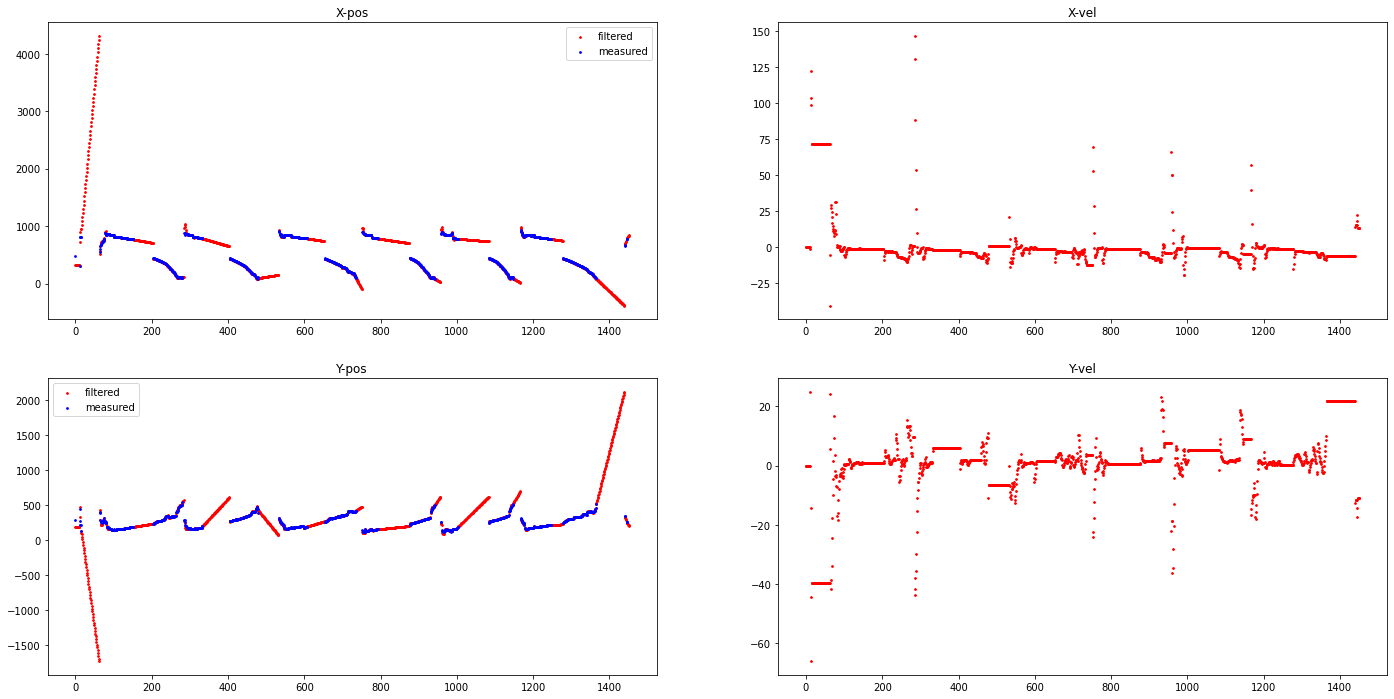

In [84]:
from kalman import *
%run kalman.py

filtered = offline_kalman(measurements)
print("Kalman filtered states", filtered.shape)

print("Average xvel:", np.mean(filtered[1, :]),"(pixels/frame)")
print("Average yvel:", np.mean(filtered[3, :]),"(pixels/frame)")


time = np.arange(0,len(xs), 1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axs[0, 0].scatter(time, filtered[0, :], s=3, c="red", label="filtered") # X-pos
axs[0, 0].scatter(time, measurements[0, :], s=3, c="blue", label="measured") # measured X-pos
axs[0, 0].set_title("X-pos")
axs[0, 0].legend()
axs[0, 1].scatter(time, filtered[1, :], s=3, c="red") # X-vel
axs[0, 1].set_title("X-vel")
axs[1, 0].scatter(time, filtered[2, :], s=3, c="red", label="filtered") # Y-pos
axs[1, 0].scatter(time, measurements[1, :], s=3, c="blue", label="measured") # Y-pos
axs[1, 0].set_title("Y-pos")
axs[1, 0].legend()
axs[1, 1].scatter(time, filtered[3, :], s=3, c="red") # Y-vel
axs[1, 1].set_title("Y-vel");